## Introduction
In today’s digital world, users are overwhelmed with the abundance of movie choices available across various platforms. As a result, deciding what to watch next has become increasingly difficult. Movie Recommendation Systems offer a practical solution to this issue by helping users discover movies tailored to their preferences, based on data and intelligent algorithms.

This project aims to build a Content-Based Movie Recommendation System that suggests similar movies to a given title using various metadata features such as genre, overview, cast, crew, and keywords. The recommendations are based on the similarity between movies, allowing the system to offer personalized suggestions without the need for explicit user ratings or interaction history.

## Technologies and Tools Used
This project leverages the following tools and technologies:
Python: Core programming language used for data processing and model development
Pandas: For data cleaning, exploration, and manipulation of movie metadata
NumPy: For numerical operations and efficient array handling
Scikit-learn: For feature extraction (e.g., TF-IDF Vectorization) and similarity measurement using cosine similarity
Natural Language Processing (NLP): To process and vectorize text data such as movie overviews and keywords
Jupyter Notebook: For interactive development and visualization
Matplotlib/Seaborn (optional): For data visualization and understanding patterns

## Data Descriptions

#### All the features in the data set are defined as follows:

1. adult : Indicates whether the movie is for adults (True or False).
2. belongs_to_collection : Contains information about the collection or franchise the movie belongs to (if any), represented as a dictionary-like string.
3. budget : The budget of the movie in USD (as a string or numeric value).
4. genres : A list of genre objects (each with id and name) associated with the movie.
5. homepage : The official website URL of the movie (if available).
4. id : The unique identifier for the movie (may be numeric or string).
5. imdb_id : The IMDb identifier of the movie (e.g., tt0114709).
6. original_language : The original language in which the movie was produced (e.g., 'en' for English).
7. original_title : The original title of the movie (before translation/localization).
8. overview : A short summary or synopsis of the movie's plot.
9. popularity : A numeric score representing the movie's popularity (used for sorting or filtering).
10. poster_path : The file path to the movie’s poster image.
11. production_companies : A list of production companies involved in making the movie, usually as dictionary-like strings.
12. production_countries : A list of countries involved in production, also in dictionary-like format.
13. release_date : The official release date of the movie (in YYYY-MM-DD format).
14. revenue : The revenue generated by the movie (in USD).
15. runtime : The length of the movie in minutes.
16. spoken_languages : A list of spoken languages in the movie, represented as dictionaries.
17. status : The release status of the movie (e.g., Released, Post Production).
18. tagline : A short marketing tagline or catchphrase for the movie.
19. title : The title of the movie (may differ from the original title due to localization).
20. video : Indicates whether the entry is a video (True or False).
21. vote_average : The average user rating for the movie (on a scale, typically out of 10).
22. vote_count : The total number of votes or ratings the movie has received.

In [ ]:
# # Installing neccessary libraries here
# ! pip install pandas
# ! pip install numpy
# ! pip install scikit-learn
# ! pip install matplotlib
# ! pip install seaborn

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import ast  # for parsing genre strings
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the movie metadata CSV file
df = pd.read_csv("movies_metadata.csv", low_memory=False)

In [3]:
#checking all the columns from datasets
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [4]:
df['genres']

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [5]:
# We only need title, genres, vote_average, and popularity for this project
movies = df[['title', 'genres', 'vote_average', 'popularity']].copy()

In [6]:
movies.isnull().sum()

title           6
genres          0
vote_average    6
popularity      5
dtype: int64

In [7]:
# Drop rows with missing values in important columns
movies = movies.dropna(subset=['genres', 'vote_average', 'popularity'])

In [8]:
#Extract genre names from JSON-like string
def parse_genres(genre_str):
    """Converts a string of genre dictionaries into a list of genre names."""
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

# Apply the parsing function to each row
movies['genre_list'] = movies['genres'].apply(parse_genres)




In [9]:
movies

,title,genres,vote_average,popularity,genre_list
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",7.7,21.946943,"[Animation, Comedy, Family]"
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,17.015539,"[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",6.5,11.7129,"[Romance, Comedy]"
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6.1,3.859495,"[Comedy, Drama, Romance]"
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",5.7,8.387519,[Comedy]
...,...,...,...,...,...
45461,Subdue,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",4.0,0.072051,"[Drama, Family]"
45462,Century of Birthing,"[{'id': 18, 'name': 'Drama'}]",9.0,0.178241,[Drama]
45463,Betrayal,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",3.8,0.903007,"[Action, Drama, Thriller]"
45464,Satan Triumphant,[],0.0,0.003503,[]


In [10]:
# inertia_values = []
# silhouette_scores = []
# k_values = range(2, 21)

# for k in k_values:
#     kmeans_model = KMeans(n_clusters=k, random_state=42)
#     kmeans_model.fit(final_features)
#     inertia_values.append(kmeans_model.inertia_)
#     silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

# # Plotting
# fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# axs[0].plot(k_values, inertia_values, marker='o')
# axs[0].set_title('Elbow Method for Optimal k')
# axs[0].set_xlabel('Number of clusters (k)')
# axs[0].set_ylabel('Inertia')
# axs[0].grid(True)

# axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
# axs[1].set_title('Silhouette Scores for Different k')
# axs[1].set_xlabel('Number of clusters (k)')
# axs[1].set_ylabel('Silhouette Score')
# axs[1].grid(True)

# plt.tight_layout()
# plt.show()

NameError: name 'final_features' is not defined

C:\Users\afroz\AppData\Local\Temp\ipykernel_23276\533219994.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


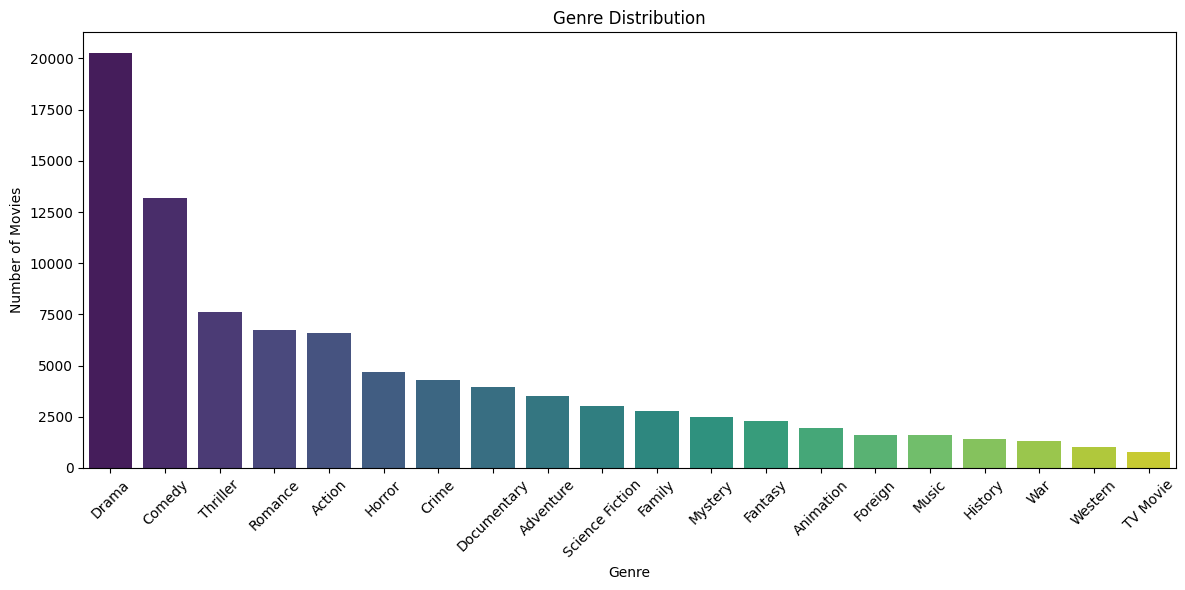

In [11]:
genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

In [12]:
# This turns genre lists into binary features
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
genre_df

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45455,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
45456,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
45457,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
45458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# We scale vote_average and popularity to range [0, 1]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['vote_average', 'popularity']])
scaled_df = pd.DataFrame(scaled_features, columns=['vote_average', 'popularity'])
scaled_df

,vote_average,popularity
0,0.77,0.040087
1,0.69,0.031079
2,0.65,0.021394
3,0.61,0.007049
4,0.57,0.015320
...,...,...
45455,0.40,0.000132
45456,0.90,0.000326
45457,0.38,0.001649
45458,0.00,0.000006


In [14]:
#Combine all features into one matrix
final_features = pd.concat([genre_df, scaled_df], axis=1)
final_features

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,vote_average,popularity
0,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.77,0.040087
1,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0.69,0.031079
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.65,0.021394
3,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0.61,0.007049
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.57,0.015320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45455,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0.40,0.000132
45456,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.90,0.000326
45457,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.38,0.001649
45458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.00,0.000006


In [ ]:
inertia_values = []
silhouette_scores = []
k_values = range(2, 21)

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Elbow Method for Optimal k')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
axs[1].set_title('Silhouette Scores for Different k')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Fit KMeans using chosen k (replace with optimal k from elbow plot)
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(final_features)

# Plot how many movies per cluster
plt.figure(figsize=(10, 5))
sns.countplot(x=movies['cluster'], palette='coolwarm')
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
#Define recommendation function
def recommend_movies(movie_title, n=5):
    """
    Recommend similar movies based on genre, popularity, and rating using clustering.
    
    Parameters:
        movie_title (str): Title of the movie to base recommendations on.
        n (int): Number of similar movies to return.
        
    Returns:
        pd.DataFrame: Top N recommended movies in the same cluster.
    """
    # Lowercase comparison for robust matching
    target = movies[movies['title'].str.lower() == movie_title.lower()]
    
    if target.empty:
        return f" Movie titled '{movie_title}' not found in dataset."
    
    # Get the cluster of the target movie
    cluster_id = target['cluster'].values[0]
    
    # Get all movies from the same cluster
    similar_movies = movies[(movies['cluster'] == cluster_id) & 
                            (movies['title'].str.lower() != movie_title.lower())]
    
    # Return top N based on vote_average and popularity
    return similar_movies[['title', 'vote_average', 'popularity']].sort_values(
        by=['vote_average', 'popularity'], ascending=False).head(n)


# Example usage:

print(" Recommended movies similar to 'Romance':")
print(recommend_movies("Romance", n=10))

In [ ]:
movies['genres']